In [16]:
import jax
from jax import grad, jit, vmap, make_jaxpr, jacfwd, jacrev, random, lax, ops
import jax.numpy as jnp

import numpy as np
import matplotlib.pyplot as plt

# States

In [5]:
# Stateful class
class Counter():

    def __init__(self, init=0):
        self.c = init

    def count(self):
        self.c += 1
        return self.c

c = Counter()

# Works
for i in range(3):
    print(c.count())

# Does NOT work
c = Counter()
jit_count = jit(c.count)
for i in range(3):
    print(jit_count())

make_jaxpr(jit_count)() # The jaxpr is just return 1

1
2
3
1
1
1


In [13]:
# Making this stateless

class StateLessCounter():
    def __init__(self):
        pass

    def reset(self):
        return 0 # return inital state

    def count(self, c):
        c += 1
        return c, c # return state_result, new_state

c = StateLessCounter()
jit_count = jit(c.count)
c_new = c.reset()
# Works with JIT
for i in range(3):
    c_res, c_new = jit_count(c_new)
    print(c_res)

make_jaxpr(jit_count)(c_new)

1
2
3


{ lambda ; a:i32[]. let
    b:i32[] c:i32[] = pjit[
      jaxpr={ lambda ; d:i32[]. let e:i32[] = add d 1 in (e, e) }
      name=count
    ] a
  in (b, c) }

# PyTrees for Stateless Designs

In [22]:
ex_pytree = [
    [1, 'a', object()],
    (1, (2,3), ()),
    [1, {'foo': 2, 'bar': 3}],
    {'foo': 2, 'bar': (3,4)},
    jnp.array([1,2,3]),
]

for ptree in ex_pytree:
    print(jax.tree_util.tree_leaves(ptree))

# Map a function over a tree
ftree = [
    {'a':3, 'b': 2},
    [1, 2, 3],
    [4, 5],
    (7, 8)
]
ftree2 = ftree
jax.tree_map(lambda x: 4 * x ** 2 , ftree)

jax.tree_map(lambda x, y: x + y, ftree, ftree2)

[1, 'a', <object object at 0x1325df850>]
[1, 2, 3]
[1, 3, 2]
[3, 4, 2]
[Array([1, 2, 3], dtype=int32)]


[{'a': 6, 'b': 4}, [2, 4, 6], [8, 10], (14, 16)]

# Creating an MLP

In [113]:
def create_params(size_list, key):
    params = []
    key, subkey = random.split(key)
    for i in range(len(size_list) - 1):

        in_shape = size_list[i]
        out_shape = size_list[i + 1]
        params.append(
            {
                'weight': random.normal(subkey, (in_shape, out_shape)) * jnp.sqrt(2/in_shape),
                'bias': jnp.ones((out_shape,))
            }
        )
        key, subkey = random.split(key)
    return params

jax.tree_map(lambda param: param.shape, create_params([1, 128, 128, 1], random.PRNGKey(0)))


[{'bias': (128,), 'weight': (1, 128)},
 {'bias': (128,), 'weight': (128, 128)},
 {'bias': (1,), 'weight': (128, 1)}]

In [114]:
import einops

def forward(params, x):
    *hidden, last = params
    for p in hidden:
        x = jax.nn.relu(einops.einsum(
            p['weight'],
            x,
            "in1 out1, batch in1 -> batch out1"
        ) + p['bias'])

    x = einops.einsum(
        last['weight'],
        x,
        "in1 out1, batch in1 -> batch out1"
    ) + last['bias']
    return x

def loss(params, x, y):
    pred = forward(params, x)
    l = jnp.mean((pred - y) ** 2)
    return l

def update(params, x, y, lr=0.0001):
    gradients = grad(loss)(params, x, y)
    return jax.tree_map(lambda param, gradient: param - lr * gradient, params, gradients)

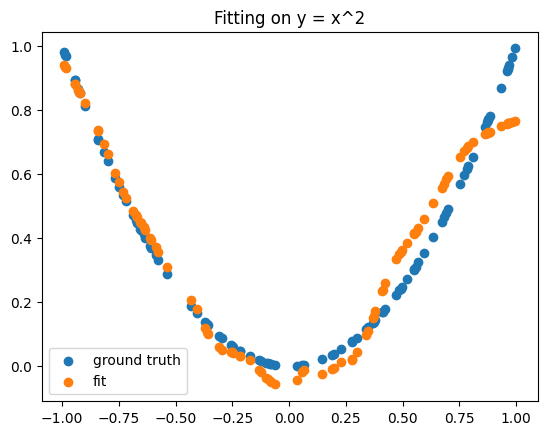

In [116]:
key = random.PRNGKey(0)
key, subkey = random.split(key)

params = create_params([1, 128, 128, 1], key)

key, subkey = random.split(subkey)
xs = random.uniform(key, (100, 1), minval=-1, maxval=1)
ys = xs ** 2

plt.scatter(xs, ys, label='ground truth')

MAX_ITER = 5000
for _ in range(MAX_ITER):
    params = update(params, xs, ys)

preds = forward(params, xs)

plt.scatter(xs, preds, label='fit')
plt.title('Fitting on y = x^2')
plt.legend()
plt.show()

# Custom PyTrees

In [118]:
class Linear():
    def __init__(self):
        self.weight = jnp.ones((10,10))
        self.bias = jnp.ones((10,))
        self.name = 'linear'

    def flatten_Linear(linear):
        # Return params and aux data
        return [linear.weight, linear.bias], linear.name

    def unflatten_Linear(aux_data, linear):
        return Linear(
            weight=linear[0],
            bias=linear[1],
            name=aux_data
        )
    
# Need to register flatten and unflatten to use in PyTree
jax.tree_util.register_pytree_node(Linear, Linear.flatten_Linear, Linear.unflatten_Linear)
custom_ptree = [
    [Linear()]
]
jax.tree_leaves(custom_ptree)

/var/folders/hr/g7g4692d5xzbk_tymkpgfq940000gn/T/ipykernel_9675/3520163057.py:23: FutureWarning: jax.tree_leaves is deprecated, and will be removed in a future release. Use jax.tree_util.tree_leaves instead.
  jax.tree_leaves(custom_ptree)


[Array([[1., 1., 1., 1., 1., 1., 1., 1., 1., 1.],
        [1., 1., 1., 1., 1., 1., 1., 1., 1., 1.],
        [1., 1., 1., 1., 1., 1., 1., 1., 1., 1.],
        [1., 1., 1., 1., 1., 1., 1., 1., 1., 1.],
        [1., 1., 1., 1., 1., 1., 1., 1., 1., 1.],
        [1., 1., 1., 1., 1., 1., 1., 1., 1., 1.],
        [1., 1., 1., 1., 1., 1., 1., 1., 1., 1.],
        [1., 1., 1., 1., 1., 1., 1., 1., 1., 1.],
        [1., 1., 1., 1., 1., 1., 1., 1., 1., 1.],
        [1., 1., 1., 1., 1., 1., 1., 1., 1., 1.]], dtype=float32),
 Array([1., 1., 1., 1., 1., 1., 1., 1., 1., 1.], dtype=float32)]